# Clasificador de flores Manual
En esta lección vamos a programar nuestro model desde 0. No usaremos transfer learning, así que no obtendremos un resultado tan bueno (o siquiera "bueno"). Haremos una red pequeña.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai as fai
import fastai.vision as fv

import torch
import torch.nn as nn
import torch.nn.functional as F

import gc
from pathlib import Path

In [3]:
flowers = Path("flowers")

In [4]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360) #tfms = transforms

In [5]:
def load_data(folder, img_size, batch_size):  
    data = (fv.ImageItemList
            .from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(tfms,size=img_size)
            .databunch(bs=batch_size))
    return data

In [6]:
data = load_data(flowers, img_size=192, batch_size=80)

## Algunas funciones de ayuda

Para nuestro primer modelo vamos a crear algunas capas y funciones de ayuda. Honestamente, no se por qué no las trae pytorch, si son bien útiles.

In [7]:
# Esta capa servirá para conectar las convolucionales con las lineales (densas)
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.squeeze()

# para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    total=0
    for p in list(model.parameters()):
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [48]:
# Primer intento: completamente manual!
model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            fai.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(384*2, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 102))
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Tanh()
  (14): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (15): Flatten()
  (16): Linear(in_features=768, out_features=256,

In [49]:
num_params(model)

1855526

In [50]:
learner = fai.Learner(data, model, metrics=fai.metrics.accuracy, wd=0.1)

In [51]:
gc.collect()

29600

In [52]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [80, 64, 96, 96]     9472       True      
______________________________________________________________________
ReLU                 [80, 64, 96, 96]     0          False     
______________________________________________________________________
MaxPool2d            [80, 64, 48, 48]     0          False     
______________________________________________________________________
Conv2d               [80, 128, 48, 48]    73856      True      
______________________________________________________________________
ReLU                 [80, 128, 48, 48]    0          False     
______________________________________________________________________
MaxPool2d            [80, 128, 24, 24]    0          False     
______________________________________________________________________
Conv2d               [80, 192, 24, 24]    221376     True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


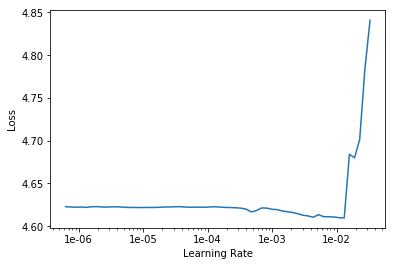

In [53]:
learner.lr_find(); learner.recorder.plot()

In [54]:
learner.fit_one_cycle(3,3e-3)

epoch,train_loss,valid_loss,accuracy
1,4.292678,4.022941,0.055336
2,3.927068,3.705933,0.098814
3,3.580068,3.454181,0.126482


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


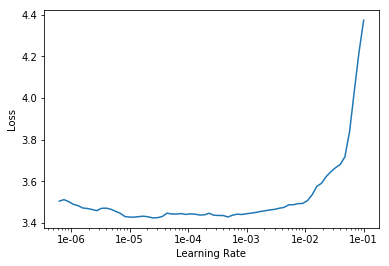

In [55]:
learner.lr_find(); learner.recorder.plot()

In [56]:
learner.fit_one_cycle(10,7e-4)

epoch,train_loss,valid_loss,accuracy
1,3.418765,3.388164,0.138340
2,3.349176,3.256197,0.162055
3,3.191569,3.055073,0.183794
4,3.014544,2.819635,0.249012
5,2.795261,2.676949,0.306324
6,2.662586,2.591237,0.296443
7,2.509741,2.440289,0.332016
8,2.407405,2.383440,0.349802
9,2.322505,2.330228,0.363636
10,2.279102,2.324035,0.357708


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


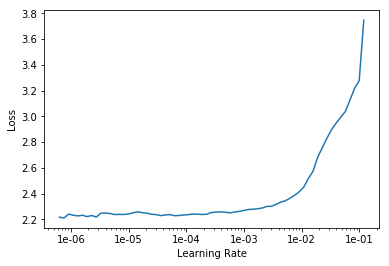

In [57]:
learner.lr_find(); learner.recorder.plot()

In [58]:
learner.fit_one_cycle(10, 2e-4)

epoch,train_loss,valid_loss,accuracy
1,2.290727,2.320266,0.365613
2,2.297191,2.346243,0.357708
3,2.283441,2.331399,0.373518
4,2.260986,2.275946,0.373518
5,2.210703,2.261972,0.379447
6,2.171837,2.234368,0.389328
7,2.108675,2.195638,0.389328
8,2.080594,2.157893,0.399209
9,2.042387,2.161715,0.395257
10,2.027963,2.155445,0.401186


# Mejorando el model inicial
Ya se ve que no vamos a llegar fácilmente a accuracy alta. Esto es por varias razones. Nos falta:

- Transfer learning
- BatchNorm
- Resnet
- Más capas

Estas últimas tres vamos a mejorarlas ahora.


## Batch norm

Primero batchnorm. Podríamos simplemente tomar el modelo que hicimos hace rato y agregar batchnorms, pero se empieza a volver *feyecito*.

**Nota**: A mi me gusta poner la activación (y BatchNorm) ANTES de las capas convolucionales. En realidad no importa para nada: finalmente van intercalados. Excepto que se me hace más fácil de programar. Les explicaré por qué en un momento.

In [59]:
def conv_block(ni, no, k=3, s=1, pad="same", bn = True, activation = True, g = 1):
    if pad == "same": 
        pad = k//2
    
    layers = []
    
    if bn:
        layers += [nn.BatchNorm2d(ni)]
       
    if activation:
        layers += [nn.LeakyReLU(inplace=True)] 
    
    layers += [nn.Conv2d(ni, no, kernel_size=k, stride=s, padding=pad, bias = not bn, groups=g)]
    
    return nn.Sequential(*layers)

`activation=False` al principio es para empezar directamente con batchnorm y no con activación. Los que ponen su activación después de la capa convolucional tendrían que poner activation=False al final

In [60]:
model = nn.Sequential(
            conv_block(3, 64, k=7, s=2, activation=False, bn=False),
            nn.MaxPool2d(2),
            conv_block(64, 128),
            nn.MaxPool2d(2),
            conv_block(128, 192),
            nn.MaxPool2d(2),
            conv_block(192, 256),
            nn.MaxPool2d(2),
            conv_block(256, 384),
            nn.Tanh(),
            fai.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2*384, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 102)
        )
num_params(model)

1855846

In [61]:
learner = fai.Learner(data, model, metrics=fai.metrics.accuracy, wd=0.05)

In [62]:
gc.collect() # pa no acabarnos la memoria. gc = garbage collector

21938

In [63]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [80, 64, 96, 96]     9472       True      
______________________________________________________________________
MaxPool2d            [80, 64, 48, 48]     0          False     
______________________________________________________________________
BatchNorm2d          [80, 64, 48, 48]     128        True      
______________________________________________________________________
LeakyReLU            [80, 64, 48, 48]     0          False     
______________________________________________________________________
Conv2d               [80, 128, 48, 48]    73728      True      
______________________________________________________________________
MaxPool2d            [80, 128, 24, 24]    0          False     
______________________________________________________________________
BatchNorm2d          [80, 128, 24, 24]    256        True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


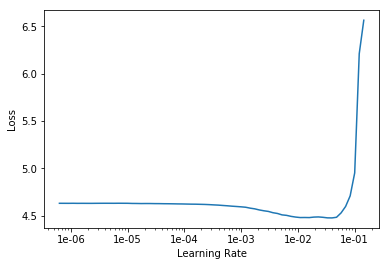

In [64]:
learner.lr_find(); learner.recorder.plot()

In [65]:
learner.fit_one_cycle(3,5e-3)

epoch,train_loss,valid_loss,accuracy
1,3.780115,5.993823,0.027668
2,3.265590,3.222798,0.150198
3,2.817585,2.641519,0.290514


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


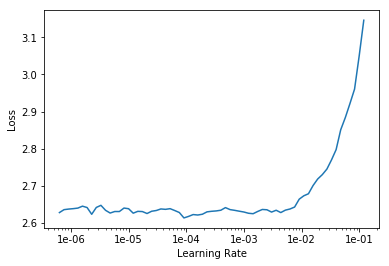

In [66]:
learner.lr_find(); learner.recorder.plot()

In [67]:
learner.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.580996,2.583441,0.286561
2,2.549238,2.584444,0.282609
3,2.454478,2.613717,0.314229
4,2.337317,3.069176,0.229249
5,2.182014,2.148923,0.411067
6,2.045830,1.965226,0.448617
7,1.922450,1.895491,0.468379
8,1.795557,1.765936,0.505929
9,1.745479,1.708989,0.511858
10,1.685590,1.709221,0.525692


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


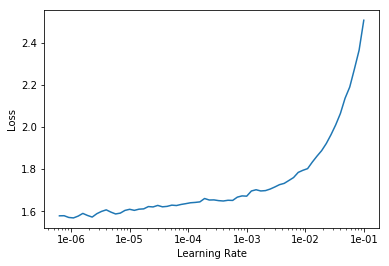

In [68]:
learner.lr_find(); learner.recorder.plot()

In [69]:
learner.fit_one_cycle(10,1e-5)

epoch,train_loss,valid_loss,accuracy
1,1.654666,1.707581,0.533597
2,1.648978,1.700261,0.523715
3,1.659799,1.695640,0.515810
4,1.660407,1.697247,0.523715
5,1.672998,1.690084,0.521739
6,1.645295,1.697702,0.519763
7,1.657007,1.692657,0.517787
8,1.641097,1.695346,0.519763
9,1.637403,1.693547,0.519763
10,1.652981,1.714459,0.521739


No está tan mal, considerando que tenemos 1/6 parte de los parámetros de resnet18:

In [70]:
print(num_params(fv.models.resnet18()))
num_params(fv.models.resnet18())/num_params(model)

11689512


6.29875108171691

## Resnets

¿Podemos hacerlo mejor? Sí, con los llamados "resblocks" (skip connections). Eso significa que guardas el resultado de una capa y la sumas un par de capas después. Esto permite entrenar redes mucho más profundas!

In [71]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        
        layers = [conv_block(nf, nf, k=3),
                  conv_block(nf, nf)]
        self.residual = nn.Sequential(*layers)
        
    def forward(self, x):
        return x + self.residual(x)

In [72]:
class Downscale(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        
        self.ap = nn.AvgPool2d(2)
        self.mp = nn.MaxPool2d(2)
        self.conv = conv_block(2*ni,no,ks=1,s=1,pad=0)
        
    def forward(self, x):
        return self.conv(torch.cat((self.ap(x), self.mp(x)), dim=1))

In [73]:
def resnet_body(filters):
    layers = [conv_block(3, filters[0], k=7, s=2, activation=False)]
    
    for ni, no in zip(filters[:-1], filters[1:]):
        layers += [nn.MaxPool2d(2), ResBlock(ni), conv_block(ni,no,g=1+(no>150))]
        
    return layers

In [74]:
layers = resnet_body([64,96,128,192,256])
layers +=[nn.Tanh(),
          fai.AdaptiveConcatPool2d(),
          Flatten(),
          nn.Dropout(0.5),
          nn.Linear(512, 256),
          nn.Dropout(0.2),
          nn.LeakyReLU(inplace=True),
          nn.Linear(256, 102)]
model = nn.Sequential(*layers)

In [75]:
num_params(model)

1865580

In [76]:
learner = fai.Learner(data, model, wd=0.1, metrics=fai.metrics.accuracy)

In [77]:
gc.collect()

22840

In [78]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          [80, 3, 192, 192]    6          True      
______________________________________________________________________
Conv2d               [80, 64, 96, 96]     9408       True      
______________________________________________________________________
MaxPool2d            [80, 64, 48, 48]     0          False     
______________________________________________________________________
BatchNorm2d          [80, 64, 48, 48]     128        True      
______________________________________________________________________
LeakyReLU            [80, 64, 48, 48]     0          False     
______________________________________________________________________
Conv2d               [80, 64, 48, 48]     36864      True      
______________________________________________________________________
BatchNorm2d          [80, 64, 48, 48]     128        True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


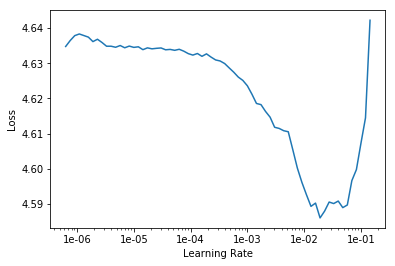

In [79]:
learner.lr_find(); learner.recorder.plot()

In [80]:
learner.fit_one_cycle(5,8e-3)

epoch,train_loss,valid_loss,accuracy
1,4.164018,3.958068,0.059289
2,3.733698,3.506348,0.140316
3,3.388423,3.128833,0.191700
4,3.050629,2.688813,0.260870
5,2.806959,2.521135,0.292490


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


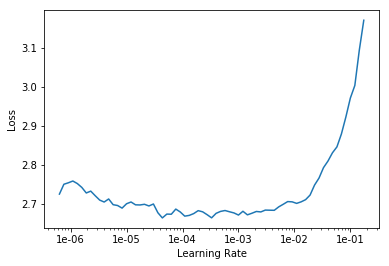

In [81]:
learner.lr_find(); learner.recorder.plot()

In [82]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.691936,2.482609,0.314229
2,2.675499,2.465589,0.298419
3,2.630057,2.433689,0.308300
4,2.540399,2.314593,0.332016
5,2.442198,2.188456,0.379447
6,2.354265,2.114517,0.375494
7,2.240711,2.018457,0.405138
8,2.173394,1.916623,0.434783
9,2.094759,1.870345,0.440711
10,2.077812,1.864883,0.450593


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


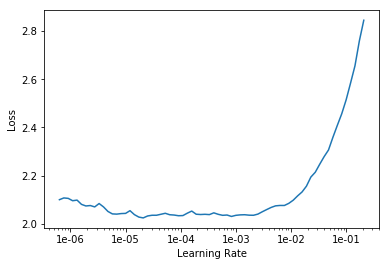

In [83]:
learner.lr_find(); learner.recorder.plot()

In [84]:
learner.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy
1,2.098429,1.957814,0.415020
2,2.182820,2.104567,0.399209
3,2.194572,2.083123,0.428854
4,2.176854,1.912506,0.472332
5,2.065768,1.821676,0.470356
6,1.926164,1.679801,0.507905
7,1.818578,1.670094,0.511858
8,1.692114,1.502007,0.555336
9,1.571648,1.431041,0.581028
10,1.523784,1.428006,0.565217


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


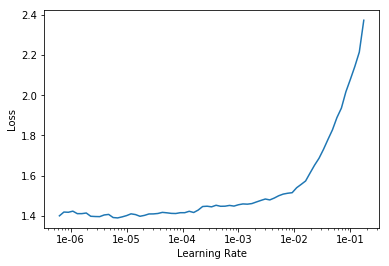

In [87]:
learner.lr_find(); learner.recorder.plot()

In [88]:
learner.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.473440,1.407732,0.577075
2,1.548378,1.549173,0.529644
3,1.588438,1.533459,0.523715
4,1.520926,1.418857,0.573123
5,1.450409,1.389262,0.592885
6,1.356363,1.263699,0.622530
7,1.299265,1.227592,0.626482
8,1.230205,1.219863,0.632411


In [89]:
learner.save('manual-resnet63')

In [90]:
learner.fit_one_cycle(8,8e-4)

epoch,train_loss,valid_loss,accuracy
1,1.259804,1.219855,0.642292
2,1.297988,1.303027,0.614625
3,1.335745,1.368779,0.598814
4,1.294317,1.395724,0.606719
5,1.226694,1.207749,0.658103
6,1.183890,1.123853,0.669960
7,1.109508,1.112245,0.673913
8,1.069379,1.091426,0.681818


In [91]:
learner.save('manual-resnet68')